# A Deep Dive into Basic Pruning of Feedforward Networks
## Author: Robert Tjarko Lange
## Date: February 2020

The structure of this notebook is as follows:
```
1. Setup the MNIST dataloaders, fix the random seed
2. Train an MLP and CNN on MNIST
3. Weight & Unit Pruning for the MNIST-MLP
4. Weight & Filter Pruning for the MNIST-CNN
5. Knowledge Distillation for the MLP network
```

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import datasets, transforms

In [2]:
# Import tools for network construction, base training & reproducibility
from helpers.utils import set_random_seeds, load_log, load_config
from helpers.utils import plot_learning, plot_pruning
from helpers.body_builder import BodyBuilder, set_optimizer, set_lrate_schedule
from helpers.logger import DeepLogger
from helpers.train_dojo import TrainDojo

# Import tools for different types of pruning
from helpers.masked_body_builder import MaskedBodyBuilder
from helpers.pruning import weight_prune_masks, unit_prune_masks, filter_prune_masks
from helpers.pruning import evaluate_pruning

## 1. Get the MNIST Data & Preprocess It

In [3]:
# Set the device on which to train
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Set training specifics which are shared across all runs
train_batch_size = 64
test_batch_size = 1000
num_epochs = 10
train_seed = 0
log_batch_interval = 300
nll_loss = nn.CrossEntropyLoss() 

# Whether to run training within this notebook
train_teachers = True
train_distill = True

# Set the random seed for reproducibility
set_random_seeds(seed_id=train_seed, verbose=True)

-- Random seeds (random, numpy, torch) were set to 0


In [4]:
# Set the PyTorch Data Loader for the training and test set
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=train_batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

## 2. Train the Set of Base Full/Teacher Networks

In [5]:
# Train the MNIST MLP for 10 Epochs - After loading in the run config
mlp_config = load_config("configs/teacher_mlp.json")
if train_teachers:
    # Construct the network architecture & optimizer
    prune_mlp = BodyBuilder(**mlp_config.net_config).to(device)
    optimizer = set_optimizer(network=prune_mlp, opt_type="Adam", l_rate=1e-4)
    
    # Initialize the logger to track learning progress
    run_log = DeepLogger(**mlp_config.log_config)
    
    # Initialize the learning dojo
    mnist_train_run = TrainDojo(network=prune_mlp, optimizer=optimizer,
                                criterion=nll_loss, device=device,
                                problem_type="classification", train_loader=train_loader,
                                test_loader=test_loader, train_log=run_log,
                                log_batch_interval=log_batch_interval)

    # Run the learning loop for a set of epochs
    mnist_train_run.train(num_epochs=num_epochs)

   num_epoch  total_batches  time_elapsed  train_accuracy  test_accuracy
0        2.0         1200.0      62.09711          0.9422         0.9417
   num_epoch  total_batches  time_elapsed  train_accuracy  test_accuracy
0        3.0         2700.0    127.281612        0.963783         0.9591
   num_epoch  total_batches  time_elapsed  train_accuracy  test_accuracy
0        5.0         4200.0     191.91032        0.974633          0.966
   num_epoch  total_batches  time_elapsed  train_accuracy  test_accuracy
0        7.0         5700.0    257.960168        0.979983         0.9701
   num_epoch  total_batches  time_elapsed  train_accuracy  test_accuracy
0        8.0         7200.0    324.283443        0.983333         0.9731
   num_epoch  total_batches  time_elapsed  train_accuracy  test_accuracy
0       10.0         8700.0    389.698682        0.987833         0.9778


In [6]:
# Train the MNIST CNN for 10 Epochs - After loading in the run config
cnn_config = load_config("configs/teacher_cnn.json")
if train_teachers:
    # Construct the network architecture & optimizer
    prune_cnn = BodyBuilder(**cnn_config.net_config).to(device)
    optimizer = set_optimizer(network=prune_cnn, opt_type="Adam", l_rate=1e-4)
    
    # Initialize the logger to track learning progress
    run_log = DeepLogger(**cnn_config.log_config)

    # Initialize the learning dojo
    mnist_train_run = TrainDojo(network=prune_cnn, optimizer=optimizer,
                                criterion=nll_loss, device=device,
                                problem_type="classification", train_loader=train_loader,
                                test_loader=test_loader, train_log=run_log,
                                log_batch_interval=log_batch_interval)
    # Run the learning loop for a set of epochs
    mnist_train_run.train(num_epochs=num_epochs)

   num_epoch  total_batches  time_elapsed  train_accuracy  test_accuracy
0        2.0         1200.0     63.312429        0.946083         0.9467
   num_epoch  total_batches  time_elapsed  train_accuracy  test_accuracy
0        3.0         2700.0    129.206506        0.969417          0.971
   num_epoch  total_batches  time_elapsed  train_accuracy  test_accuracy
0        5.0         4200.0    194.761923        0.977133         0.9776
   num_epoch  total_batches  time_elapsed  train_accuracy  test_accuracy
0        7.0         5700.0    259.849149          0.9818         0.9805
   num_epoch  total_batches  time_elapsed  train_accuracy  test_accuracy
0        8.0         7200.0    324.731123        0.983133         0.9798
   num_epoch  total_batches  time_elapsed  train_accuracy  test_accuracy
0       10.0         8700.0    389.932905        0.986917         0.9856


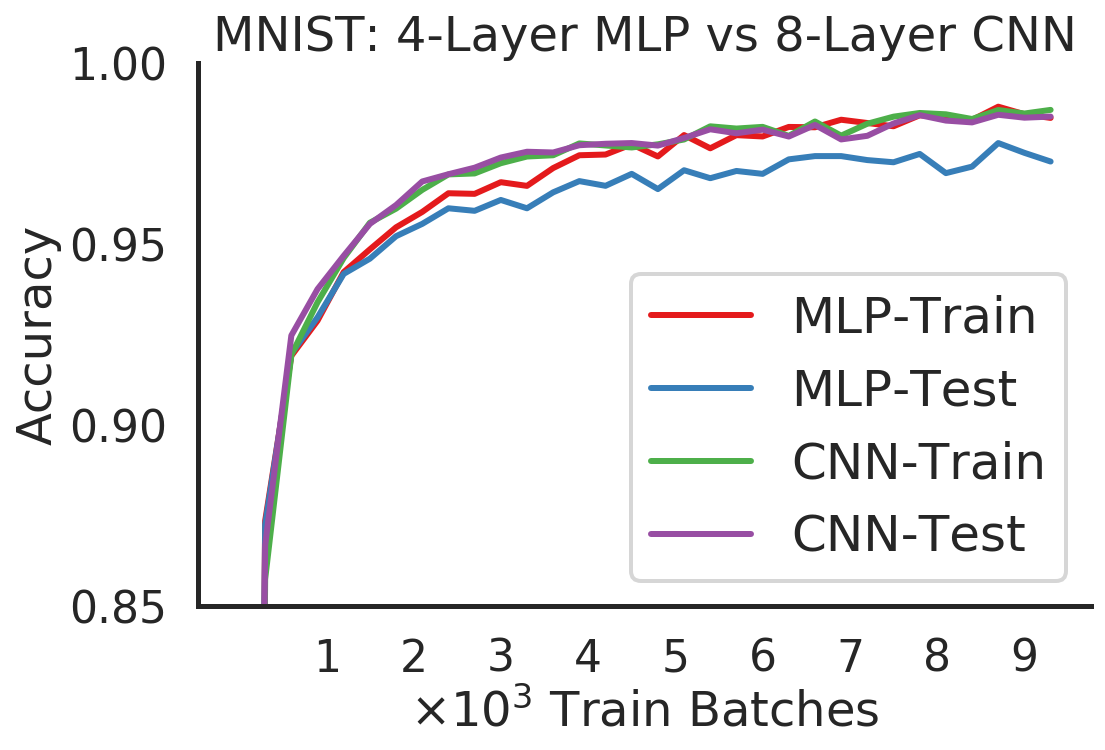

In [7]:
# Visualize the learning log
results_mlp = load_log(log_fname="logs/mnist_mlp.hdf5")
results_cnn = load_log(log_fname="logs/mnist_cnn.hdf5")

plot_learning(results_mlp.total_batches["mean"].ravel(),
                    stats_mean_list=[results_mlp.train_accuracy["mean"],
                                     results_mlp.test_accuracy["mean"],
                                     results_cnn.train_accuracy["mean"],
                                     results_cnn.test_accuracy["mean"]],
                    stats_std_list=None,
                    labels=["MLP-Train", "MLP-Test", "CNN-Train", "CNN-Test"],
                    title="MNIST: 4-Layer MLP vs 8-Layer CNN", ylabel="Accuracy",
                    step_size=1000,
                    y_lim=[0.85, 1.], filter_ws=0, legend_loc=0,
                    xlabel=r"$\times 10^3$ Train Batches")

## 3. Perform Weight & Unit Pruning on the MLP

In [8]:
sparsity_levels = [0, 25, 50, 60, 70, 80, 90, 95, 97, 99]

mlp_path = "networks/mnist_mlp.ckpth"
accuracy_weight = evaluate_pruning(mlp_config.net_config, mlp_path,
                                   nll_loss, device, test_loader,
                                   sparsity_levels, prune_type="weight")

accuracy_unit = evaluate_pruning(mlp_config.net_config, mlp_path,
                                 nll_loss, device, test_loader,
                                 sparsity_levels, prune_type="unit")

Type: weight | Sparsity (Exluding Readout): 0.00 | Test Accuracy: 0.973
Type: weight | Sparsity (Exluding Readout): 0.25 | Test Accuracy: 0.972
Type: weight | Sparsity (Exluding Readout): 0.50 | Test Accuracy: 0.971
Type: weight | Sparsity (Exluding Readout): 0.60 | Test Accuracy: 0.970
Type: weight | Sparsity (Exluding Readout): 0.70 | Test Accuracy: 0.968
Type: weight | Sparsity (Exluding Readout): 0.80 | Test Accuracy: 0.966
Type: weight | Sparsity (Exluding Readout): 0.90 | Test Accuracy: 0.956
Type: weight | Sparsity (Exluding Readout): 0.95 | Test Accuracy: 0.856
Type: weight | Sparsity (Exluding Readout): 0.97 | Test Accuracy: 0.674
Type: weight | Sparsity (Exluding Readout): 0.99 | Test Accuracy: 0.289
Type: unit | Sparsity (Exluding Readout): 0.00 | Test Accuracy: 0.973
Type: unit | Sparsity (Exluding Readout): 0.25 | Test Accuracy: 0.956
Type: unit | Sparsity (Exluding Readout): 0.50 | Test Accuracy: 0.783
Type: unit | Sparsity (Exluding Readout): 0.60 | Test Accuracy: 0.643


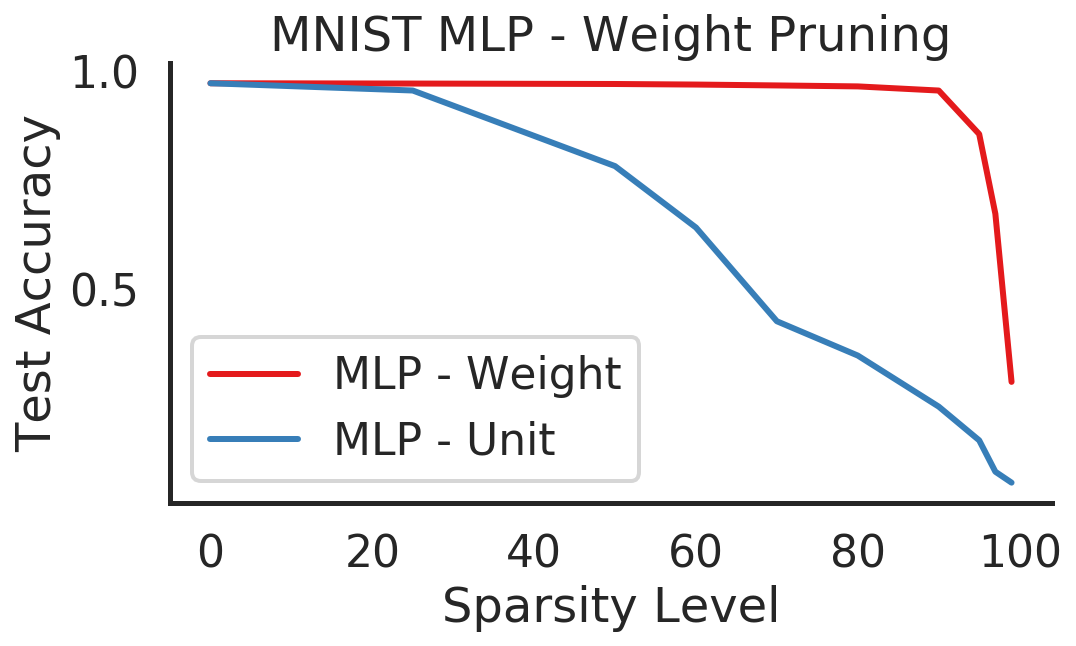

In [9]:
# Plot the Pruning Technique Comparison - MLP
plot_pruning(sparsity_levels, accuracy_weight, accuracy_unit,
             labels=["MLP - Weight", "MLP - Unit"],
             title = "MNIST MLP - Weight Pruning")

## 4. Perform Weight & Filter Pruning on the CNN

In [10]:
cnn_path = "networks/mnist_cnn.ckpth"
accuracy_weight = evaluate_pruning(cnn_config.net_config, cnn_path,
                                   nll_loss, device, test_loader,
                                   sparsity_levels, prune_type="weight")

# Note: Sparsity Levels include linear layers in calculation
# We dont prune those but still account for in the total number of params!
# Hence, the calculation is off - Conv Params make up most of the params!
accuracy_filter = evaluate_pruning(cnn_config.net_config, cnn_path,
                                   nll_loss, device, test_loader,
                                   sparsity_levels, prune_type="filter")

Type: weight | Sparsity (Exluding Readout): 0.00 | Test Accuracy: 0.985
Type: weight | Sparsity (Exluding Readout): 0.25 | Test Accuracy: 0.985
Type: weight | Sparsity (Exluding Readout): 0.50 | Test Accuracy: 0.982
Type: weight | Sparsity (Exluding Readout): 0.60 | Test Accuracy: 0.984
Type: weight | Sparsity (Exluding Readout): 0.70 | Test Accuracy: 0.983
Type: weight | Sparsity (Exluding Readout): 0.80 | Test Accuracy: 0.978
Type: weight | Sparsity (Exluding Readout): 0.90 | Test Accuracy: 0.725
Type: weight | Sparsity (Exluding Readout): 0.95 | Test Accuracy: 0.153
Type: weight | Sparsity (Exluding Readout): 0.97 | Test Accuracy: 0.109
Type: weight | Sparsity (Exluding Readout): 0.99 | Test Accuracy: 0.103
Type: filter | Sparsity (Exluding Readout): 0.00 | Test Accuracy: 0.985
Type: filter | Sparsity (Exluding Readout): 0.02 | Test Accuracy: 0.916
Type: filter | Sparsity (Exluding Readout): 0.04 | Test Accuracy: 0.398
Type: filter | Sparsity (Exluding Readout): 0.05 | Test Accuracy

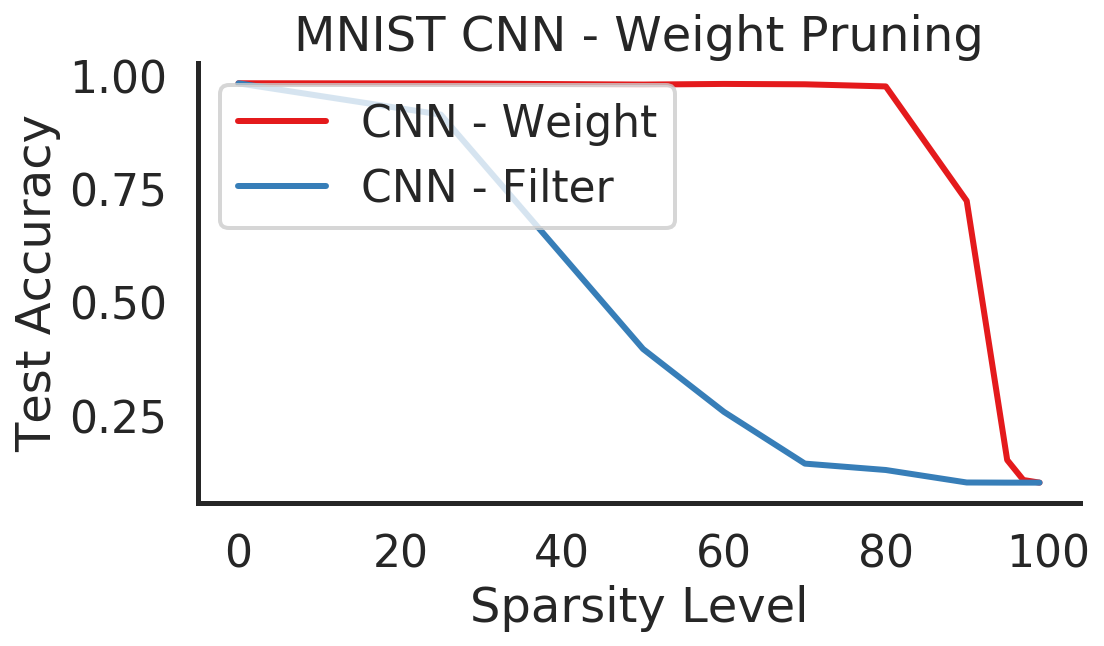

In [11]:
# Plot the Pruning Technique Comparison
plot_pruning(sparsity_levels, accuracy_weight, accuracy_filter,
             labels=["CNN - Weight", "CNN - Filter"],
             title = "MNIST CNN - Weight Pruning")

## 5. a) Knowledge Distillation - MLP Base Configs ($\alpha=0.4$, $\tau=20$)

In [12]:
from helpers.train_dojo import DistillDojo

In [16]:
# Load in the trained teacher network
teacher_mlp = BodyBuilder(**mlp_config.net_config, load_in_path="networks/mnist_mlp.ckpth").to(device)
print("Trainable Params Teacher: {}".format(teacher_mlp.get_num_trainable_params()))
# Cut of the softmax head to get logits - need to do so for soft distillation loss
teacher_mlp = nn.Sequential(*list(teacher_mlp.model)[:-1])

# Define the student network
student_config_1 = load_config("configs/student_1_mlp.json")
student_mlp_1 = BodyBuilder(**student_config_1.net_config).to(device)
print("Trainable Params Student: {}".format(student_mlp_1.get_num_trainable_params()))

Trainable Params Teacher: 2386000
Trainable Params Student: 266880


In [17]:
# Train the Teacher MLP for 10 Epochs - with larger lrate/slower schedule
# Gradient signal is more informative since we use dark knowledge
optimizer = set_optimizer(network=student_mlp_1, opt_type="Adam", l_rate=1e-3)

run_log = DeepLogger(**student_config_1.log_config)

mnist_train_run = DistillDojo(teacher_network=teacher_mlp, alpha=0.4, tau=20.,
                              network=student_mlp_1, optimizer=optimizer,
                              device=device,
                              problem_type="classification", train_loader=train_loader,
                              test_loader=test_loader, train_log=run_log,
                              log_batch_interval=log_batch_interval)
mnist_train_run.train(num_epochs=5)

   num_epoch  total_batches  time_elapsed  train_accuracy  test_accuracy
0        2.0         1200.0     62.458691        0.967633         0.9613
   num_epoch  total_batches  time_elapsed  train_accuracy  test_accuracy
0        3.0         2700.0    126.195034        0.982767         0.9726
   num_epoch  total_batches  time_elapsed  train_accuracy  test_accuracy
0        5.0         4200.0    191.459571        0.987033         0.9718


In [18]:
student_config_2 = load_config("configs/student_2_mlp.json")
student_mlp_2 = BodyBuilder(**student_config_2.net_config).to(device)
print("Trainable Params Student: {}".format(student_mlp_2.get_num_trainable_params()))

Trainable Params Student: 63104


In [20]:
# Train the Teacher MLP for 10 Epochs - with larger lrate/slower schedule
# Gradient signal is more informative since we use dark knowledge
optimizer = set_optimizer(network=student_mlp_2, opt_type="Adam", l_rate=1e-3)

run_log = DeepLogger(**student_config_2.log_config)

mnist_train_run = DistillDojo(teacher_network=teacher_mlp, alpha=0.4, tau=20.,
                              network=student_mlp_2, optimizer=optimizer,
                              device=device,
                              problem_type="classification", train_loader=train_loader,
                              test_loader=test_loader, train_log=run_log,
                              log_batch_interval=log_batch_interval)
mnist_train_run.train(num_epochs=5)

   num_epoch  total_batches  time_elapsed  train_accuracy  test_accuracy
0        2.0         1200.0     62.205513        0.954783         0.9503
   num_epoch  total_batches  time_elapsed  train_accuracy  test_accuracy
0        3.0         2700.0    127.400623          0.9733          0.962
   num_epoch  total_batches  time_elapsed  train_accuracy  test_accuracy
0        5.0         4200.0    192.031269        0.980567         0.9692


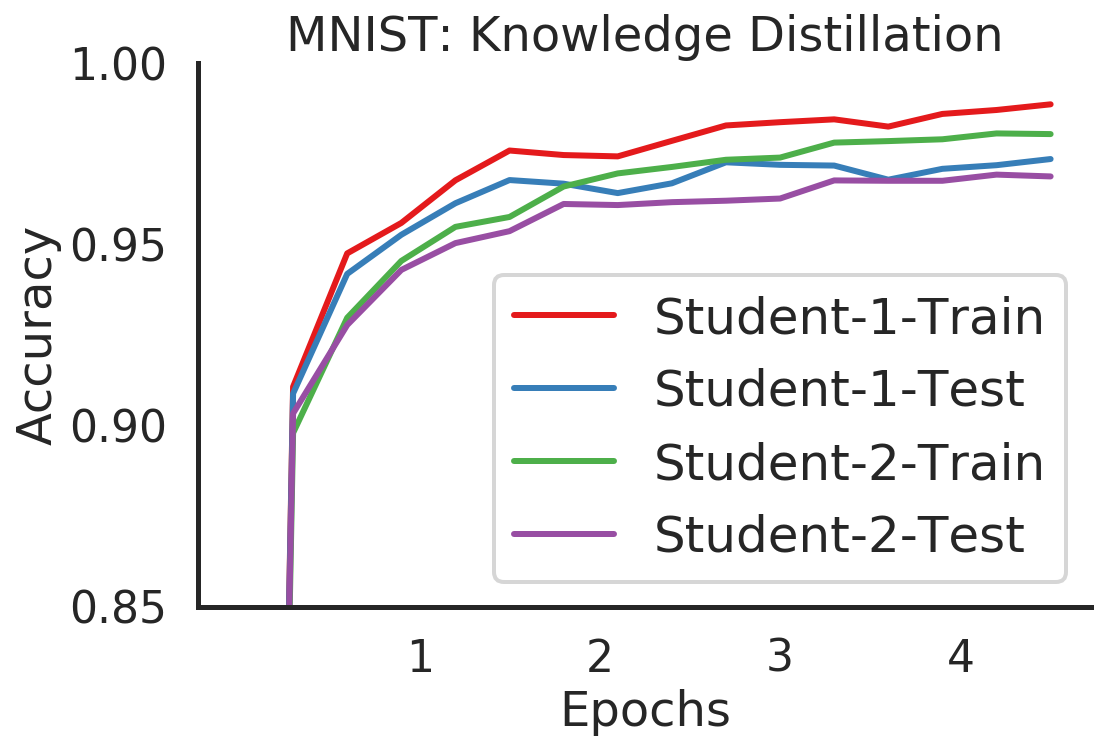

In [36]:
results_student_1 = load_log(log_fname="logs/mnist_mlp_student_1.hdf5")
results_student_2 = load_log(log_fname="logs/mnist_mlp_student_2.hdf5")

plot_learning(results_student_1.total_batches["mean"],
                stats_mean_list=[results_student_1.train_accuracy["mean"],
                                 results_student_1.test_accuracy["mean"],
                                 results_student_2.train_accuracy["mean"],
                                 results_student_2.test_accuracy["mean"]],
                stats_std_list=None,
                labels=["Student-1-Train", "Student-1-Test", "Student-2-Train", "Student-2-Test"],
                title="MNIST: Knowledge Distillation", ylabel="Accuracy",
                step_size=1000,
                y_lim=[0.85, 1.], filter_ws=0, legend_loc=0,
                xlabel=r"Epochs")